Name: Karthik Venugopal

USC ID: 9330529336

github username: Karthikvenugopal

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import shutil
import random
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [2]:
def separating_dataset_train_test(source_dir, dest_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-5, "Ratios must sum to 1"
    random.seed(seed)

    for class_name in filter(lambda x: os.path.isdir(os.path.join(source_dir, x)), os.listdir(source_dir)):
        class_path = os.path.join(source_dir, class_name)
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(images)

        n_total = len(images)
        n_train = int(train_ratio * n_total)
        n_val = int(val_ratio * n_total)

        splits = {
            'train': images[:n_train],
            'val': images[n_train:n_train + n_val],
            'test': images[n_train + n_val:]
        }

        for split, split_images in splits.items():
            split_dir = os.path.join(dest_dir, split, class_name)
            os.makedirs(split_dir, exist_ok=True)
            for img in split_images:
                shutil.copy2(os.path.join(class_path, img), os.path.join(split_dir, img))

    print(f"Dataset split completed and saved to {dest_dir}")


In [3]:
separating_dataset_train_test(source_dir="RealWaste", dest_dir="SeparatedWaste", train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42)

Dataset split completed and saved to SeparatedWaste


In [4]:
base_dir = "SeparatedWaste"
sub_dirs = {split: os.path.join(base_dir, split) for split in ["train", "val", "test"]}

img_size = (224, 224)
batch_size = 5

preprocess_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

data_gens = {
    split: preprocess_gen.flow_from_directory(
        sub_dirs[split],
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=(split == "train")
    )
    for split in ["train", "val", "test"]
}

train_gen = data_gens["train"]
val_gen = data_gens["val"]
test_gen = data_gens["test"]
epochs = 100


Found 3323 images belonging to 9 classes.
Found 710 images belonging to 9 classes.
Found 719 images belonging to 9 classes.


In [5]:
img_height, img_width = img_size
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)
base_model.trainable = False
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [6]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=40,
    restore_best_weights=True
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model_resnet50.h5',
    monitor='val_loss',
    save_best_only=True
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


665/665 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.3798 - loss: 7.8173

665/665 ━━━━━━━━━━━━━━━━━━━━ 121s 180ms/step - accuracy: 0.3800 - loss: 7.8159 - val_accuracy: 0.6014 - val_loss: 5.3412
Epoch 2/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.5766 - loss: 5.0556

665/665 ━━━━━━━━━━━━━━━━━━━━ 131s 197ms/step - accuracy: 0.5766 - loss: 5.0550 - val_accuracy: 0.6944 - val_loss: 3.6341
Epoch 3/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.6176 - loss: 3.6278

665/665 ━━━━━━━━━━━━━━━━━━━━ 141s 213ms/step - accuracy: 0.6176 - loss: 3.6276 - val_accuracy: 0.7268 - val_loss: 2.7671
Epoch 4/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.6231 - loss: 2.8935

665/665 ━━━━━━━━━━━━━━━━━━━━ 148s 222ms/step - accuracy: 0.6231 - loss: 2.8933 - val_accuracy: 0.6958 - val_loss: 2.3563
Epoch 5/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 143s 214ms/step - accuracy: 0.6170 - loss: 2.5265 - val_accuracy: 0.5577 - val_loss: 2.6133
Epoch 6/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.6314 - loss: 2.2485

665/665 ━━━━━━━━━━━━━━━━━━━━ 155s 233ms/step - accuracy: 0.6314 - loss: 2.2484 - val_accuracy: 0.6901 - val_loss: 1.9631
Epoch 7/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.6361 - loss: 2.0635

665/665 ━━━━━━━━━━━━━━━━━━━━ 150s 225ms/step - accuracy: 0.6361 - loss: 2.0635 - val_accuracy: 0.6789 - val_loss: 1.8693
Epoch 8/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 152s 229ms/step - accuracy: 0.6292 - loss: 2.0493 - val_accuracy: 0.4014 - val_loss: 2.9360
Epoch 9/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.6467 - loss: 1.8495

665/665 ━━━━━━━━━━━━━━━━━━━━ 154s 231ms/step - accuracy: 0.6467 - loss: 1.8494 - val_accuracy: 0.6901 - val_loss: 1.6282
Epoch 10/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.6497 - loss: 1.7432

665/665 ━━━━━━━━━━━━━━━━━━━━ 154s 231ms/step - accuracy: 0.6497 - loss: 1.7432 - val_accuracy: 0.7268 - val_loss: 1.4438
Epoch 11/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 155s 233ms/step - accuracy: 0.6548 - loss: 1.6550 - val_accuracy: 0.6986 - val_loss: 1.4619
Epoch 12/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.6562 - loss: 1.6330

665/665 ━━━━━━━━━━━━━━━━━━━━ 156s 235ms/step - accuracy: 0.6562 - loss: 1.6330 - val_accuracy: 0.7310 - val_loss: 1.3520
Epoch 13/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 156s 235ms/step - accuracy: 0.6626 - loss: 1.5875 - val_accuracy: 0.6479 - val_loss: 1.6217
Epoch 14/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 158s 237ms/step - accuracy: 0.6545 - loss: 1.5866 - val_accuracy: 0.6845 - val_loss: 1.4548
Epoch 15/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.6545 - loss: 1.5670

665/665 ━━━━━━━━━━━━━━━━━━━━ 160s 241ms/step - accuracy: 0.6545 - loss: 1.5670 - val_accuracy: 0.7254 - val_loss: 1.2584
Epoch 16/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 155s 234ms/step - accuracy: 0.6416 - loss: 1.5659 - val_accuracy: 0.6085 - val_loss: 1.6853
Epoch 17/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 155s 233ms/step - accuracy: 0.6907 - loss: 1.4615 - val_accuracy: 0.7127 - val_loss: 1.3131
Epoch 18/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 159s 239ms/step - accuracy: 0.6728 - loss: 1.5064 - val_accuracy: 0.7070 - val_loss: 1.4072
Epoch 19/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 158s 237ms/step - accuracy: 0.6543 - loss: 1.5606 - val_accuracy: 0.6451 - val_loss: 1.5574
Epoch 20/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.6607 - loss: 1.4780

665/665 ━━━━━━━━━━━━━━━━━━━━ 160s 241ms/step - accuracy: 0.6607 - loss: 1.4780 - val_accuracy: 0.7408 - val_loss: 1.2288
Epoch 21/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.6780 - loss: 1.3945

665/665 ━━━━━━━━━━━━━━━━━━━━ 161s 242ms/step - accuracy: 0.6780 - loss: 1.3946 - val_accuracy: 0.7634 - val_loss: 1.1606
Epoch 22/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 159s 239ms/step - accuracy: 0.6838 - loss: 1.3625 - val_accuracy: 0.6408 - val_loss: 1.5784
Epoch 23/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 157s 235ms/step - accuracy: 0.6681 - loss: 1.4933 - val_accuracy: 0.7282 - val_loss: 1.2993
Epoch 24/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 158s 237ms/step - accuracy: 0.6767 - loss: 1.4433 - val_accuracy: 0.6592 - val_loss: 1.5024
Epoch 25/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 157s 237ms/step - accuracy: 0.6935 - loss: 1.3931 - val_accuracy: 0.6746 - val_loss: 1.3649
Epoch 26/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.6816 - loss: 1.4006

665/665 ━━━━━━━━━━━━━━━━━━━━ 159s 238ms/step - accuracy: 0.6816 - loss: 1.4006 - val_accuracy: 0.7648 - val_loss: 1.1205
Epoch 27/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 159s 238ms/step - accuracy: 0.7070 - loss: 1.2868 - val_accuracy: 0.7169 - val_loss: 1.2912
Epoch 28/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 155s 233ms/step - accuracy: 0.7186 - loss: 1.2223 - val_accuracy: 0.6746 - val_loss: 1.3942
Epoch 29/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.7188 - loss: 1.2482

665/665 ━━━━━━━━━━━━━━━━━━━━ 156s 235ms/step - accuracy: 0.7188 - loss: 1.2482 - val_accuracy: 0.7338 - val_loss: 1.1082
Epoch 30/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 159s 239ms/step - accuracy: 0.6961 - loss: 1.2542 - val_accuracy: 0.6915 - val_loss: 1.3658
Epoch 31/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 160s 241ms/step - accuracy: 0.7092 - loss: 1.2582 - val_accuracy: 0.7183 - val_loss: 1.2616
Epoch 32/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 164s 247ms/step - accuracy: 0.7060 - loss: 1.2917 - val_accuracy: 0.7282 - val_loss: 1.2002
Epoch 33/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 164s 246ms/step - accuracy: 0.7094 - loss: 1.2765 - val_accuracy: 0.7338 - val_loss: 1.1162
Epoch 34/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 167s 250ms/step - accuracy: 0.7137 - loss: 1.2113 - val_accuracy: 0.6493 - val_loss: 1.4544
Epoch 35/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.6432 - loss: 1.4441

665/665 ━━━━━━━━━━━━━━━━━━━━ 168s 253ms/step - accuracy: 0.6432 - loss: 1.4441 - val_accuracy: 0.7563 - val_loss: 1.1081
Epoch 36/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.6938 - loss: 1.2648

665/665 ━━━━━━━━━━━━━━━━━━━━ 160s 240ms/step - accuracy: 0.6938 - loss: 1.2648 - val_accuracy: 0.7648 - val_loss: 1.0886
Epoch 37/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 165s 248ms/step - accuracy: 0.7140 - loss: 1.2350 - val_accuracy: 0.7493 - val_loss: 1.1025
Epoch 38/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 166s 249ms/step - accuracy: 0.6934 - loss: 1.2806 - val_accuracy: 0.7099 - val_loss: 1.2585
Epoch 39/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 165s 248ms/step - accuracy: 0.7089 - loss: 1.2523 - val_accuracy: 0.7493 - val_loss: 1.1038
Epoch 40/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.7125 - loss: 1.2217

665/665 ━━━━━━━━━━━━━━━━━━━━ 166s 250ms/step - accuracy: 0.7125 - loss: 1.2217 - val_accuracy: 0.7634 - val_loss: 0.9991
Epoch 41/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 165s 248ms/step - accuracy: 0.7379 - loss: 1.1319 - val_accuracy: 0.6648 - val_loss: 1.3721
Epoch 42/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 167s 251ms/step - accuracy: 0.6959 - loss: 1.2487 - val_accuracy: 0.7254 - val_loss: 1.1856
Epoch 43/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 170s 256ms/step - accuracy: 0.7086 - loss: 1.2639 - val_accuracy: 0.7775 - val_loss: 1.0254
Epoch 44/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 169s 253ms/step - accuracy: 0.7338 - loss: 1.1520 - val_accuracy: 0.7648 - val_loss: 1.0372
Epoch 45/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 169s 255ms/step - accuracy: 0.7231 - loss: 1.1600 - val_accuracy: 0.7366 - val_loss: 1.1591
Epoch 46/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 171s 257ms/step - accuracy: 0.7054 - loss: 1.2396 - val_accuracy: 0.7394 - val_loss: 1.1480
Epoch 47/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 170s 256ms/step - accuracy: 0.725

665/665 ━━━━━━━━━━━━━━━━━━━━ 169s 254ms/step - accuracy: 0.7183 - loss: 1.1747 - val_accuracy: 0.7592 - val_loss: 0.9952
Epoch 60/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 164s 246ms/step - accuracy: 0.7320 - loss: 1.1328 - val_accuracy: 0.7563 - val_loss: 1.0628
Epoch 61/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 165s 249ms/step - accuracy: 0.7248 - loss: 1.1283 - val_accuracy: 0.7690 - val_loss: 1.0248
Epoch 62/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 167s 251ms/step - accuracy: 0.7298 - loss: 1.1375 - val_accuracy: 0.7690 - val_loss: 1.0038
Epoch 63/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 169s 254ms/step - accuracy: 0.7415 - loss: 1.0824 - val_accuracy: 0.7099 - val_loss: 1.1605
Epoch 64/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.7354 - loss: 1.1077

665/665 ━━━━━━━━━━━━━━━━━━━━ 171s 257ms/step - accuracy: 0.7354 - loss: 1.1077 - val_accuracy: 0.7704 - val_loss: 0.9827
Epoch 65/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.7428 - loss: 1.0786

665/665 ━━━━━━━━━━━━━━━━━━━━ 175s 263ms/step - accuracy: 0.7428 - loss: 1.0786 - val_accuracy: 0.7775 - val_loss: 0.9766
Epoch 66/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.7518 - loss: 1.0560

665/665 ━━━━━━━━━━━━━━━━━━━━ 172s 259ms/step - accuracy: 0.7517 - loss: 1.0561 - val_accuracy: 0.7704 - val_loss: 0.9655
Epoch 67/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 170s 256ms/step - accuracy: 0.7504 - loss: 1.0824 - val_accuracy: 0.6817 - val_loss: 1.4297
Epoch 68/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 172s 258ms/step - accuracy: 0.7225 - loss: 1.1686 - val_accuracy: 0.7141 - val_loss: 1.1641
Epoch 69/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 172s 259ms/step - accuracy: 0.7568 - loss: 1.0761 - val_accuracy: 0.7789 - val_loss: 0.9950
Epoch 70/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 171s 258ms/step - accuracy: 0.7507 - loss: 1.0591 - val_accuracy: 0.7239 - val_loss: 1.1530
Epoch 71/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 171s 257ms/step - accuracy: 0.7555 - loss: 1.0551 - val_accuracy: 0.7056 - val_loss: 1.1826
Epoch 72/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 170s 255ms/step - accuracy: 0.7211 - loss: 1.1413 - val_accuracy: 0.6718 - val_loss: 1.2952
Epoch 73/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 172s 258ms/step - accuracy: 0.717

665/665 ━━━━━━━━━━━━━━━━━━━━ 167s 252ms/step - accuracy: 0.7279 - loss: 1.1278 - val_accuracy: 0.7901 - val_loss: 0.9378
Epoch 100/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 168s 253ms/step - accuracy: 0.7232 - loss: 1.1353 - val_accuracy: 0.6577 - val_loss: 1.2886


In [7]:
model.save('final_resnet50_model.keras')

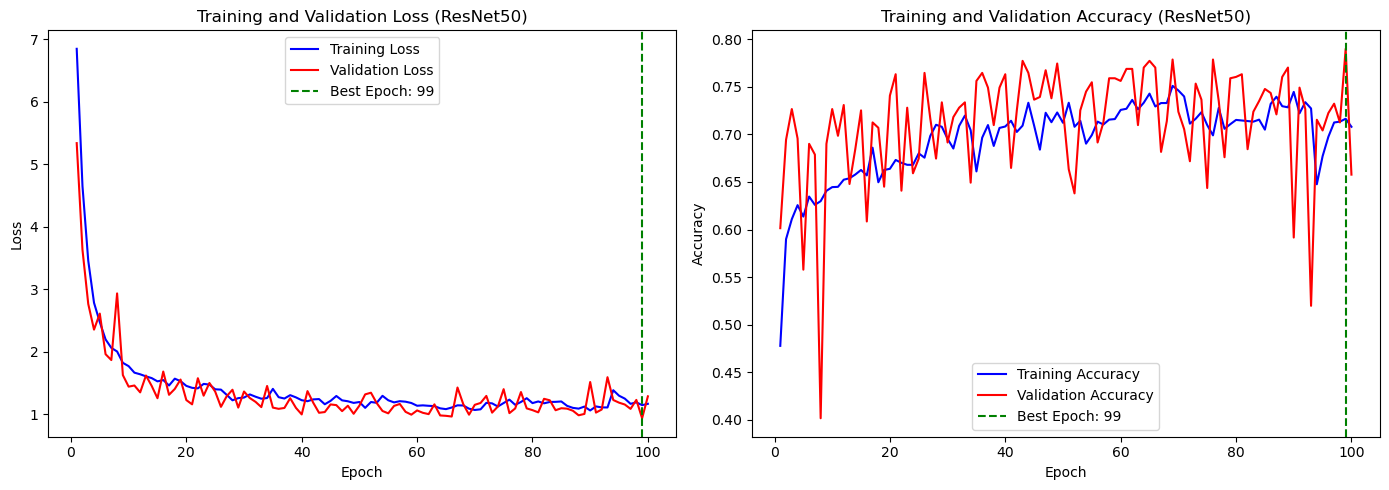

In [10]:
history_df = pd.DataFrame(history.history)

epoch_range = np.arange(1, len(history_df) + 1)
best_epoch_resnet = np.argmin(history_df['val_loss']) + 1

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(epoch_range, history_df['loss'], 'b', label='Training Loss')
axes[0].plot(epoch_range, history_df['val_loss'], 'r', label='Validation Loss')
axes[0].axvline(x=best_epoch_resnet, color='g', linestyle='--', label=f'Best Epoch: {best_epoch_resnet}')
axes[0].set_title('Training and Validation Loss (ResNet50)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Accuracy plot
axes[1].plot(epoch_range, history_df['accuracy'], 'b', label='Training Accuracy')
axes[1].plot(epoch_range, history_df['val_accuracy'], 'r', label='Validation Accuracy')
axes[1].axvline(x=best_epoch_resnet, color='g', linestyle='--', label=f'Best Epoch: {best_epoch_resnet}')
axes[1].set_title('Training and Validation Accuracy (ResNet50)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()


In [11]:
y_test_probs = model.predict(test_gen, verbose=0)
y_test_preds = np.argmax(y_test_probs, axis=1)
y_test_true = test_gen.classes

class_names = [f"{i+1}-{name}" for i, name in enumerate(test_gen.class_indices)]

report_df = pd.DataFrame(
    classification_report(
        y_test_true,
        y_test_preds,
        target_names=class_names,
        output_dict=True
    )
).T.round(2)

summary_rows = ['accuracy', 'macro avg', 'weighted avg']
class_rows = [row for row in report_df.index if row not in summary_rows]
report_df = report_df.loc[class_rows + summary_rows]

print("\n Classification Report for ResNet50 on Test Set:\n")
print(report_df.to_string())



 Classification Report for ResNet50 on Test Set:

                         precision  recall  f1-score  support
1-1-Cardboard                 0.66    0.81      0.73    70.00
2-2-Food Organics             0.81    0.83      0.82    63.00
3-3-Glass                     0.81    0.83      0.82    63.00
4-4-Metal                     0.80    0.82      0.81   119.00
5-5-Miscellaneous Trash       0.80    0.47      0.59    75.00
6-6-Paper                     0.93    0.51      0.66    75.00
7-7-Plastic                   0.70    0.83      0.76   139.00
8-8-Textile Trash             0.73    0.84      0.78    49.00
9-9-Vegetation                0.83    0.97      0.90    66.00
accuracy                      0.77    0.77      0.77     0.77
macro avg                     0.79    0.77      0.76   719.00
weighted avg                  0.78    0.77      0.76   719.00
